# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
3319,7819,52771,NaN,18-03-2020,A deluge of retailer emails today re plans re ...,Positive
27245,37219,82171,"Deptford SE8 London, UK",08-04-2020,Our new Pepys Social Supermarket with @lewisha...,Extremely Positive
21945,30588,75540,NaN,02-04-2020,Food insecurity was hitting TN amp the US befo...,Extremely Negative
11125,17300,62252,NaN,21-03-2020,Scott Well said Tom stay safe we middle class ...,Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [3]:
df['Sentiment'].unique() # получим все уникальные значения

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [4]:
from sklearn.preprocessing import FunctionTransformer

function_transformer = FunctionTransformer(lambda x: x.isin(['Positive', 'Extremely Positive']).astype(int))
df['SentimentCode'] = function_transformer.fit_transform(df[['Sentiment']]) # пока оставим Sentiment для наглядности

Сбалансированы ли классы?

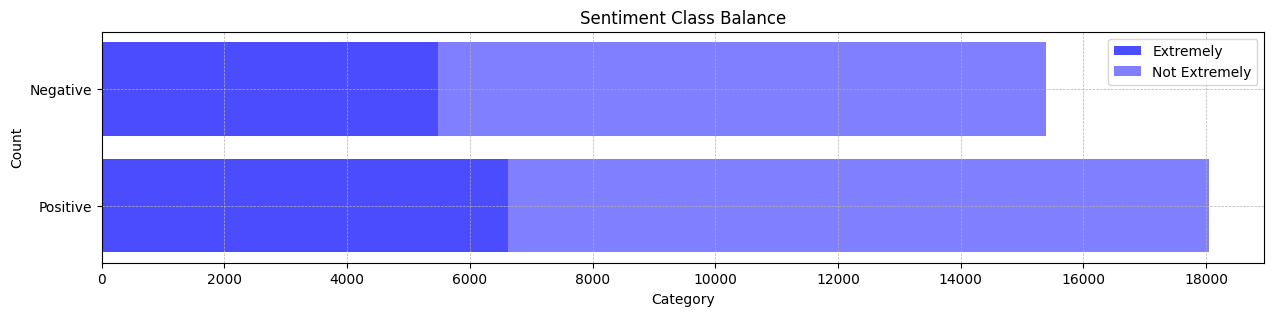

In [5]:
sentiment_counts = pd.DataFrame({
    'Category' : ['Positive', 'Negative'], 
    'Extremely' : [df[df['Sentiment'] == 'Extremely Positive'].shape[0], df[df['Sentiment'] == 'Extremely Negative'].shape[0]],
    'Not Extremely' : [df[df['Sentiment'] == 'Positive'].shape[0], df[df['Sentiment'] == 'Negative'].shape[0]]
})
plt.figure(figsize=(15, 3))
plt.barh(sentiment_counts['Category'], sentiment_counts['Extremely'], label='Extremely', color='blue', alpha=0.7)
plt.barh(sentiment_counts['Category'], sentiment_counts['Not Extremely'], left=sentiment_counts['Extremely'], label='Not Extremely', color='blue', alpha=0.5)
plt.xticks([i for i in range(0, 18001, 2000)])
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Sentiment Class Balance')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

**Ответ:** с уверенностью можно сказать, что классы сбалансированны&

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [6]:
print(df.isna().sum())
df[df.isna()] = 'Unknown'

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
SentimentCode       0
dtype: int64


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

In [8]:
train['SentimentCode'].value_counts(), test['SentimentCode'].value_counts() # параметр stratify можно не настраивать, разбиение равномерно + в последующих заданиях будут возникать несостыковки

(SentimentCode
 1    12564
 0    10846
 Name: count, dtype: int64,
 SentimentCode
 1    5482
 0    4552
 Name: count, dtype: int64)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [9]:
from nltk.probability import FreqDist # аналог counter-a из collections, только из Natural Language Toolkit

all_tokens = []

for tweet in train['OriginalTweet']:
    tokens = tweet.lower().split() 
    all_tokens.extend(tokens)

freq_dist = FreqDist(all_tokens)

Какой размер словаря получился?

In [10]:
print(len(freq_dist))

79755


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [11]:
freq_dist.most_common(10)

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** Все токены кроме #coronavirus напрямую относятся к лексике английзкого языка и не отражают какой-то смысл или тенденцию - эти слова также часто будут встречаться в твитах по любой теме (стоп слова). Поскольку мы анализируем твиты о коронавирусе, не удивительно что токен '#coronavirus' встречается часто (чаще чем само слово coronavirus), так как является предметом обсуждения, а человек вместо 'coronavirus' пишет '#coronavirus', видимо так модно.

In [12]:
freq_dist['coronavirus']

970

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [13]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

keys_to_delete = [key for key in freq_dist.keys() if key in stop_words]
for key in keys_to_delete:
    del freq_dist[key]

In [14]:
freq_dist.most_common(10)

[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

**Ответ:**  Список изменился. Можно предположить, что в твитах часто обсуждают сам вирус, а также неприятности, с ним связанные (возможно повышение цен, сложности с посещением магазинов и тд). &amp - какая-то [штука](https://stackoverflow.com/questions/9084237/what-is-amp-used-for) из HTML.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [15]:
freq_dist.most_common()[:-21:-1]

[('https://t.co/7j2y3rsld9', 1),
 ('@680news', 1),
 ('@torontopearson', 1),
 ('nothing...', 1),
 ('flew', 1),
 ('wage!', 1),
 ('renewing', 1),
 ('playersã\x82â\x92', 1),
 ('subsidise', 1),
 ('non-playing', 1),
 ('premiership', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('#southkerry', 1),
 ('#skelligcoast2kms', 1),
 ('@skelligsix18', 1),
 ('closer!)', 1),
 ('coast!', 1),
 ('skellig', 1)]

**Ответ:** Среди этих слов встречаются ссылки (возможно уникальны, не знаю как их [преобразует](https://t.co) твиттер), имена пользователей (уникальны), также слова со знаками !, они тоже влияют на уникальность, ошибки кодировки, редкие формы глаголов, спецлексика. Такие слова не отражают тональность текста, поэтому дополнительно работать с ними не нужно.

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [16]:
from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer()
all_tokens = []
for tweet in train['OriginalTweet']:
    all_tokens.extend(tweet_tokenizer.tokenize(tweet.lower()))

freq_dist2 = FreqDist(all_tokens)
freq_dist2.most_common(10)

[('the', 26993),
 ('.', 24118),
 ('to', 23478),
 (',', 17571),
 ('and', 14825),
 ('of', 13044),
 ('a', 11891),
 ('in', 11348),
 ('?', 9524),
 ('#coronavirus', 8808)]

**Ответ:** Снова 9 из 10 - stop words и пунктуация. Этот токенайзер отделяет знаки пунктуации. Токенов '#coronavirus' нашел немного больше, чем прошлый, из-за отделения знаков пунктуации (#coronavirus == #coronavirus! == #coronavirus. == #coronavirus? ...).

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [17]:
keys_to_delete = [key for key in freq_dist2.keys() if key in punctuation or key in stop_words]
for key in keys_to_delete:
    del freq_dist2[key]
    
freq_dist2.most_common(10)

[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

**Ответ:** Всё кроме трёх токенов может относится к теме, 'â', '\x82', '\x92' - какие-то [ошибки](https://stackoverflow.com/questions/15602038/syntaxerror-non-utf-8-code-starting-with-x82) между кодировками Windows и UTF-8

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [18]:
for p in freq_dist2:
    if len(p) == 1 and ord(p) >= 128:
        del freq_dist2[p]

freq_dist2.most_common(10), freq_dist2.most_common()[:-21:-1]

([('#coronavirus', 8808),
  ('19', 7167),
  ('covid', 6253),
  ('prices', 4601),
  ('food', 4367),
  ('store', 3877),
  ('supermarket', 3805),
  ('grocery', 3523),
  ('people', 3463),
  ('#covid19', 2589)],
 [('https://t.co/7j2y3rsld9', 1),
  ('@680news', 1),
  ('@torontopearson', 1),
  ('flew', 1),
  ('renewing', 1),
  ('playersã', 1),
  ('subsidise', 1),
  ('non-playing', 1),
  ('premiership', 1),
  ('https://t.co/iaek4fwsgz', 1),
  ('@srinivasiyc', 1),
  ('https://t.co/zjcl195vqs', 1),
  ('#southkerry', 1),
  ('#skelligcoast2kms', 1),
  ('@skelligsix18', 1),
  ('skellig', 1),
  ('milion', 1),
  ('now.when', 1),
  ('https://t.co/5cbliqzx7l', 1),
  ('https://t.co/lw1r0rm7xs', 1)])

**Ответ:** Второй топ лучше, в нем 'food,' == 'food' == 'food!' (напрмер), он отделяет пунктуацию, разделяет сокращения, отделяет '-' от чисел, в нем удалены символы разметки HTML, stopwords и пунктуация.

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [19]:
count = 0
for p in sorted(freq_dist2, reverse=True, key=freq_dist2.get):
    if p.startswith('#'):
        print(p, ' : ', freq_dist2[p])
        count += 1
    if count == 10:
        break

#coronavirus  :  8808
#covid19  :  2589
#covid_19  :  1734
#covid2019  :  946
#toiletpaper  :  744
#covid  :  641
#socialdistancing  :  465
#coronacrisis  :  448
#pandemic  :  257
#coronaviruspandemic  :  249


**Ответ:** Не слышал этих слов (кроме #toiletpaper) до коронавируса - они напрямую относятся к теме, но с #toiletpaper тогда тоже остро вопрос стоял

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [20]:
count = 0
for tweet in sorted(freq_dist2, reverse=True, key=freq_dist2.get):
    if tweet.startswith('https://t.co'): # другие ссылки можно не учитывать, в твиттере разрешены только 't.co...'
        if count < 10: 
            print(tweet, ' : ', freq_dist2[tweet])
        count += 1
print(f'Всего ссылок: {count}')

https://t.co/oxa7swtond  :  5
https://t.co/gp3eusapl8  :  4
https://t.co/deftrui1pfãâ  :  3
https://t.co/wrlhyzizaa  :  3
https://t.co/kuwipf1kqw  :  3
https://t.co/zjnrx6dkkn  :  3
https://t.co/3gbbdpdjat  :  3
https://t.co/e2znxajpre  :  3
https://t.co/catkegayoy  :  3
https://t.co/g63rp042ho  :  3
Всего ссылок: 12797


**Ответ:**  Ссылки, видимо, уже утеряны (не нашел работающих), и в целом ссылок много, но для самой популярной из них - 5 вхождений, поэтому они не могут отражать какой-то тендеции и зависимостей. Ссылки в данном случае не полезны.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [21]:
from nltk.corpus import stopwords
from string import punctuation

def custom_tokenizer(text):
    tknz = TweetTokenizer()
    tokens = tknz.tokenize(text.lower())

    stop_words = set(stopwords.words('english'))
    _punctuation = set(punctuation)

    tokens = [token for token in tokens if (token not in stop_words) and (token not in _punctuation) and not (len(token) == 1 and ord(token) >= 128) and (not token.startswith('https://t.co'))]

    return tokens

In [22]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer).fit(train['OriginalTweet'])

len(cv.vocabulary_)

45290

**Ответ:** Размер словаря стал намного меньше, так как теперь обрабатываются stop words, пунктуация, ссылки, токены из одного символа с ord >=128 и прочие вещи, о которх было сказано ранее.

Посмотрим на какой-нибудь конкретный твитт:

In [24]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 'Negative')

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску. (кстати нет, просто негативную)

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [25]:
pd.DataFrame(cv.transform([train.iloc[ind]['OriginalTweet']]).toarray(), columns=cv.get_feature_names_out()).T.sort_values(by=0, ascending=False).head(14)

,0
panic,1
lets,1
brainless,1
queueing,1
food,1
@skynews,1
show,1
#covid2019,1
france,1
ppl,1


**Ответ:** Определить самый важный/не важный токен не получится, поскольку это CountVectorizer для твита из обучающей выборки. Он просто делает подсчет вхождений токенов из словаря в этот твит, так как обучались, в том числе на этом твите и в твите нет повторяющихся слов, то везде 1.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfv = TfidfVectorizer(tokenizer=custom_tokenizer).fit(train['OriginalTweet'])
pd.DataFrame(tfidfv.transform([train.iloc[ind]['OriginalTweet']]).toarray(), columns=tfidfv.get_feature_names_out()).T.sort_values(by=0, ascending=False).head(14)

,0
brainless,0.386764
queueing,0.354346
ffs,0.324474
france,0.320473
@skynews,0.310426
lets,0.301211
ppl,0.255006
nice,0.254273
show,0.244065
#coronavirusoutbreak,0.225843


**Ответ:** Хорошо: наибольший вес получили токены brainless, ffs (for ~~fuck's~~ sake), nice, ppl(people), france, queueing. Эти слова ближе к тому, чтобы отражать желаемое. (самый неважный - 'food', самый важный - 'brainless'). TfidfVectorizer присваивает большие значения токенам с большим TF * IDF, а меньшие - токенам с низким TF * IDF. TF-IDF характеризует важность токена во всем корпусе.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [27]:
positive_words = r'good|great|amazing|wonderful|beautiful'
train[train['OriginalTweet'].str.contains(positive_words, case=False, regex=True) & (train['Sentiment'] == 'Extremely Positive')]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,SentimentCode
28899,39249,84201,India,09-04-2020,@Canon_India I am very happy.. Great job by @C...,Extremely Positive,1
192,4035,48987,"San Diego, CA",16-03-2020,"What's a good way to support grocery store, me...",Extremely Positive,1
21892,30522,75474,Snuneymuxw territory (Nanaimo),02-04-2020,Still not sure how to best get groceries durin...,Extremely Positive,1
21883,30511,75463,London,02-04-2020,Coronavirus career pivots: 'I now work in a su...,Extremely Positive,1
23519,32529,77481,"Moulton, England",05-04-2020,Well done James great front of store before we...,Extremely Positive,1
...,...,...,...,...,...,...,...
6250,11382,56334,"Mumbai, India",19-03-2020,Respected Sir @narendramodi \r\r\n\r\r\nWe und...,Extremely Positive,1
21533,30068,75020,"Almaty, Kazakhstan",02-04-2020,Good news Grants First Approval of Convalescen...,Extremely Positive,1
18987,26911,71863,Unknown,25-03-2020,@AmyPoythress I hope you &amp; your family rem...,Extremely Positive,1
469,4365,49317,TaÃÂ¯wan,16-03-2020,#COVID19 19 A friend of mine in the US works a...,Extremely Positive,1


In [28]:
positive_tweet = '\n'.join(train[train['ScreenName'] == 82433]['OriginalTweet'].tolist())
positive_tweet

'Amazing and admirable work being done by all grocery store companies and workers.  #SuddenChange #ThankYou\r\r\n\r\r\nÃ\x82Â\x93All hands on deckÃ\x82Â\x92: Grocery store executives get a taste of the hard life on coronavirus front lines | Financial Post https://t.co/oAM2HBk7MP'

In [29]:
from googletrans import Translator
t = await Translator().translate(positive_tweet, dest='russian') # перведем на русский ( как-то не очень получилось(( )
t.text

'Удивительная и восхитительная работа, выполняемая всеми компаниями и работниками продуктового магазина.  #Suddenchange #thankyou\r\r\n\r\r\nВсе руки на Deckã: руководители продуктового магазина почувствуют вкус тяжелой жизни на фронте коронавируса | Финансовый пост https://t.co/oam2hbk7mp'

In [30]:
pd.DataFrame(tfidfv.transform(train[train['ScreenName'] == 82433]['OriginalTweet']).toarray(), columns=tfidfv.get_feature_names_out()).T.sort_values(by=0, ascending=False).head(22)

,0
#suddenchange,0.345875
admirable,0.322752
deckã,0.304083
#thankyou,0.253381
taste,0.251358
executives,0.249451
amazing,0.213425
grocery,0.196085
lines,0.195945
store,0.190265


**Ответ:** #suddenchange, admirable, amazing - самые важные токены, тк обладают высоким TF-IDF во всем контексте. Эти слова могут отражать тональность текста.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [31]:
X_train, y_train = train['OriginalTweet'], train['SentimentCode']
X_test, y_test = test['OriginalTweet'], test['SentimentCode']

In [32]:
cv = CountVectorizer(tokenizer=custom_tokenizer).fit(X_train)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [33]:
tfidfv = TfidfVectorizer(tokenizer=custom_tokenizer).fit(X_train)
X_train_tf = tfidfv.transform(X_train)
X_test_tf = tfidfv.transform(X_test)

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_cv = LogisticRegression().fit(X_train_cv, y_train)
lr_tfidfv = LogisticRegression().fit(X_train_tf, y_train)

print(f'Accuracy CountVec: train - {accuracy_score(y_train, lr_cv.predict(X_train_cv)):.2f}, test - {accuracy_score(y_test, lr_cv.predict(X_test_cv)):.2f}')
print(f'Accuracy TfidfVec: train - {accuracy_score(y_train, lr_tfidfv.predict(X_train_tf)):.2f}, test - {accuracy_score(y_test, lr_tfidfv.predict(X_test_tf)):.2f}')

Accuracy CountVec: train - 0.98, test - 0.87
Accuracy TfidfVec: train - 0.92, test - 0.85


**Ответ:** CountVectorizer показал лучший результат на тесте, хотя он в большей степени переобучен, чем TFIDFVectorizer. Лучше использовать модель c TFIDF, ее обобщающие способности выше, хоть и показала меньше на 0.02 на тесте.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [35]:
from nltk.stem import SnowballStemmer

def custom_stem_tokenizer(text):
    sst = SnowballStemmer('english')
    tokens = custom_tokenizer(text)
    for i in range(len(tokens)):
        tokens[i] = sst.stem(tokens[i])

    return tokens

In [36]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [37]:
cv = CountVectorizer(input='content', tokenizer=custom_stem_tokenizer).fit(X_train)
len(cv.vocabulary_)

36634

**Ответ** Размер словаря уменьшился, так как слова были сведены к корню, поэтому отдельные формы и однокоренные аналогичны. 
  
Пример из документации:   
*            feed		->		feed  
*   		agreed		->		agree  
*        plastered		->		plaster  
*       	bled		->		bled  
*        motoring		->		motor  
*           sing		->		sing  

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [38]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer).fit(X_train)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [39]:
tfidfv = TfidfVectorizer(tokenizer=custom_stem_tokenizer).fit(X_train)
X_train_tf = tfidfv.transform(X_train)
X_test_tf = tfidfv.transform(X_test)

In [40]:
lr_cv = LogisticRegression().fit(X_train_cv, y_train)
lr_tfidfv = LogisticRegression().fit(X_train_tf, y_train)

print(f'Accuracy CountVec: train - {accuracy_score(y_train, lr_cv.predict(X_train_cv)):.2f}, test - {accuracy_score(y_test, lr_cv.predict(X_test_cv)):.2f}')
print(f'Accuracy TfidfVec: train - {accuracy_score(y_train, lr_tfidfv.predict(X_train_tf)):.2f}, test - {accuracy_score(y_test, lr_tfidfv.predict(X_test_tf)):.2f}')

Accuracy CountVec: train - 0.97, test - 0.87
Accuracy TfidfVec: train - 0.92, test - 0.86


**Ответ:** Качество изменилось незначительно, в данном случае нет смысла применять стемминг, но можно присмотреться, если важна производительность.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было) <span style="color:red">(но у меня было 36634)</span>. Почему параметр получился такой большой/маленький?

In [41]:
"""Найдем max_df"""
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer).fit_transform(train['OriginalTweet'])
max_df = np.max((cv_df > 0).sum(axis=0).A1) / cv_df.shape[0] # максимум из количества вхождений каждого слова / количество док-ов

print(f"max_df = {max_df}")

max_df = 0.3742417770183682


In [42]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=max_df).fit(train['OriginalTweet'])
print(len(cv.vocabulary_))

36634


**Ответ:** Значение именно такое, тк учитывается количество документов, в которых было вхождение токена, а не асолютное число вхождений, таким образом #coronavirus есть примерно в 37% твитов

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [43]:
"""Найдем min_df"""
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer).fit_transform(X_train)
min_df = np.sort((cv_df > 0).sum(axis=0).A1)[::-1][3700 - 1] / cv_df.shape[0] # находим df 3700 - го токена (по убыванию вхождений)

print(f"min_df = {min_df}")

min_df = 0.00042716787697565144


In [44]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=round(min_df, 5)).fit(X_train)
print(len(cv.vocabulary_))
# Ближайшее большее значение - 3918, видимо в этом диапазоне все слова обладают одинковым количеством вхождений.

3687


In [45]:
np.sort((cv_df > 0).sum(axis=0).A1)[::-1][3685 : 3920] # ну да

array([11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10

In [46]:
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

lr_cv = LogisticRegression().fit(X_train_cv, y_train)

print(f'Accuracy CountVec: train - {accuracy_score(y_train, lr_cv.predict(X_train_cv)):.2f}, test - {accuracy_score(y_test, lr_cv.predict(X_test_cv)):.2f}')

Accuracy CountVec: train - 0.93, test - 0.87


**Ответ:** Качество осталось на прежнем уровне, переобучение снизилось, тк кол-во признаков меньше, модель стала лучше.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [47]:
from sklearn.preprocessing import StandardScaler

X_train_cv = X_train_cv.toarray()
X_test_cv = X_test_cv.toarray()

scaler = StandardScaler()
X_train_cv = scaler.fit_transform(X_train_cv)
X_test_cv = scaler.transform(X_test_cv)

lr_cv = LogisticRegression().fit(X_train_cv, y_train)

print(f'Accuracy CountVec: train - {accuracy_score(y_train, lr_cv.predict(X_train_cv)):.2f}, test - {accuracy_score(y_test, lr_cv.predict(X_test_cv)):.2f}')

Accuracy CountVec: train - 0.94, test - 0.84


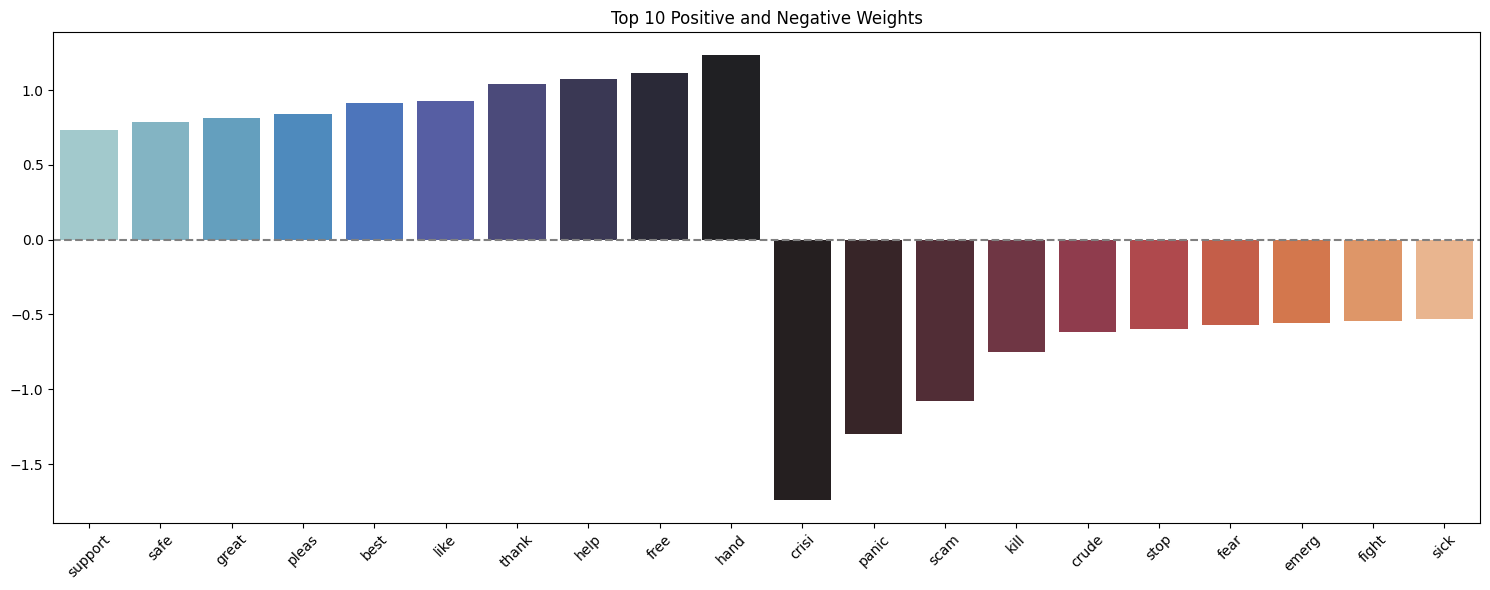

In [48]:
coef_df = list(zip(cv.get_feature_names_out(), lr_cv.coef_[0]))
coef_df = sorted(coef_df, key=lambda x: x[1])

top_neg = coef_df[:10]
top_pos = coef_df[-10:]
top_words = top_pos + top_neg

words = [w for w, _ in top_words]
weights = [w for _, w in top_words]

plt.figure(figsize=(15, 6))
sns.barplot(x=words, y=weights, palette='icefire')
plt.title('Top 10 Positive and Negative Weights')
plt.xticks(rotation=45)
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

**Ответ:** Слова, представленные на графике слева действительно имеет положительную окраску, по этому имеют наибольший положительный вес. Слова же, представленные спрва имеют резко негативную окраску, поэтрому их веса сильно отрицательны.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

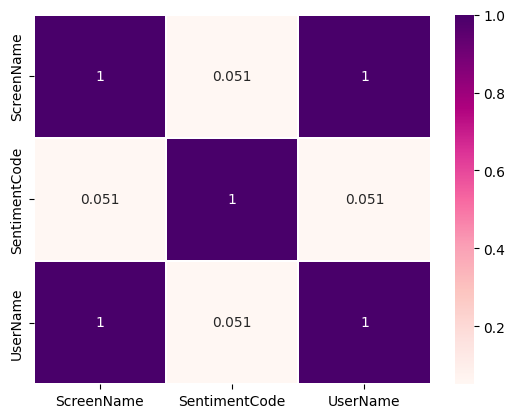

In [49]:
sns.heatmap(df[['ScreenName', 'SentimentCode', 'UserName']].corr(), annot=True, linewidths=0.3, cmap='RdPu')
plt.show()

**Ответ:** Признаки UserName и ScreenName бесполезны, они не могут иметь никакой связи с твитами, так как уникальны для каждого твита и случайны или  составлены на основе имен, но точно не имеют зависимостей с целевой переменной. К тому же, никак не кореллируют с целевой переменной.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

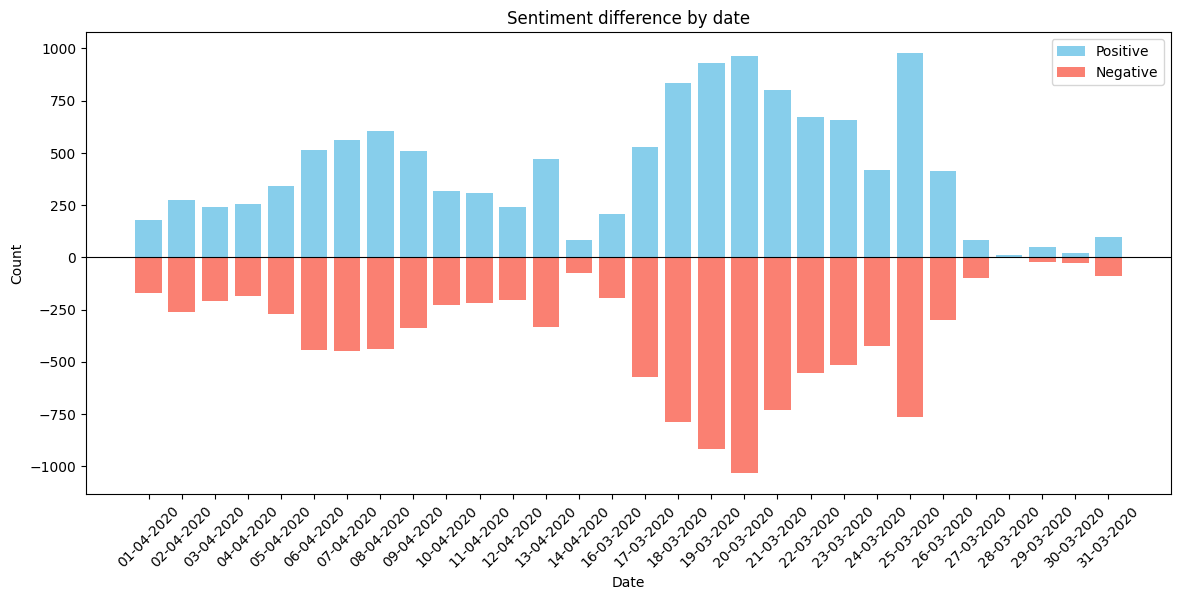

In [50]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'], dayfirst=True)

counts = train.groupby(['TweetAt', 'SentimentCode']).size().unstack(fill_value=0)
counts['Positive'] = counts[1]
counts['Negative'] = -counts[0]

plt.figure(figsize=(14, 6))
plt.bar(counts.index, counts['Positive'], label='Positive', color='skyblue')
plt.bar(counts.index, counts['Negative'], label='Negative', color='salmon')
plt.axhline(0, color='black', linewidth=0.8)
plt.title('Sentiment difference by date')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.show()

**Ответ:** Не видно никаких зависимостей между датой и разницей в количестве твитов каждой окраски - положительных твитов почти всегда немного больше (выборка сбалансирована, но не идеальна). Возможно, если бы рассматриваемый период данных был больше (например, от начала и до конца пандемии), то можно было бы увидеть какую-то динамику в изменении настроения пользователей Хтвиттера

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [51]:
train['Location'].nunique()

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

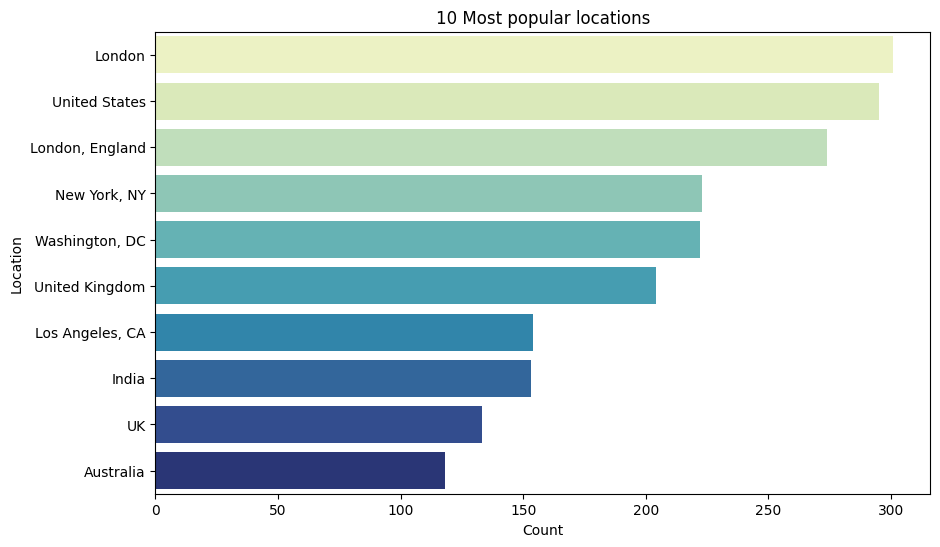

In [52]:
plt.figure(figsize=(10, 6))
top10 = train[train['Location'] != 'Unknown']['Location'].value_counts().head(10)
sns.barplot(y=top10.index, x=top10.values, palette='YlGnBu')
plt.title('10 Most popular locations')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [53]:
"""Считаю, что здесь можно применить для всего фрейма, поскольку алгоритм статичен и работает одинаково для 'новых' и для 'старых' данных"""     
    
def mapping(location : str) -> str:
    if location == "Unknown":
        return location
    
    keyword_map = { # что-то очевидное и то, что часто встречается можно прописать вручную
        'usa': 'USA', 'united states': 'USA', 'us': 'USA', 'u.s.': 'USA', 'texas': 'USA', 'new york': 'USA',
        'ny': 'USA', 'ca': 'USA', 'il': 'USA', 'co': 'USA', 'virginia': 'USA', 'fort worth': 'USA',
        'uk': 'UK', 'england': 'UK', 'london': 'UK', 'united kingdom' : 'UK',
        'canada': 'Canada', 'bc': 'Canada',
        'india': 'India',
        'south africa': 'South Africa', 'midrand': 'South Africa',
        'north america': 'North America'
            }  

    location = location.strip().lower()

    for key in keyword_map:
        if key in location:
            return keyword_map[key]

    if ',' in location:
        parts = [p.strip().upper() for p in location.split(',')]
        if parts[-1] in keyword_map.values(): 
            return parts[-1]
        if len(parts) >= 2 and parts[-2] in keyword_map.values():
            return parts[-2]
        return parts[-1] 
    else:
        return location
     
df['WiderLocation'] = df['Location'].astype(str).apply(lambda x: mapping(str(x)))
df['WiderLocation'].value_counts()

WiderLocation
USA                             10042
Unknown                          7052
UK                               3228
India                             920
DC                                336
                                ...  
GB                                  1
STOKE ON TRENT!                     1
under the goldy fish                1
tyuretye - alice springs.           1
i love you so much || he/him        1
Name: count, Length: 3953, dtype: int64

In [54]:
df[(df['Location'] == 'Unknown') & (df['Location'] != df['WiderLocation'])][['Location', 'WiderLocation']].sum().sum()
# Вроде ничего лишнего не поменяли

0

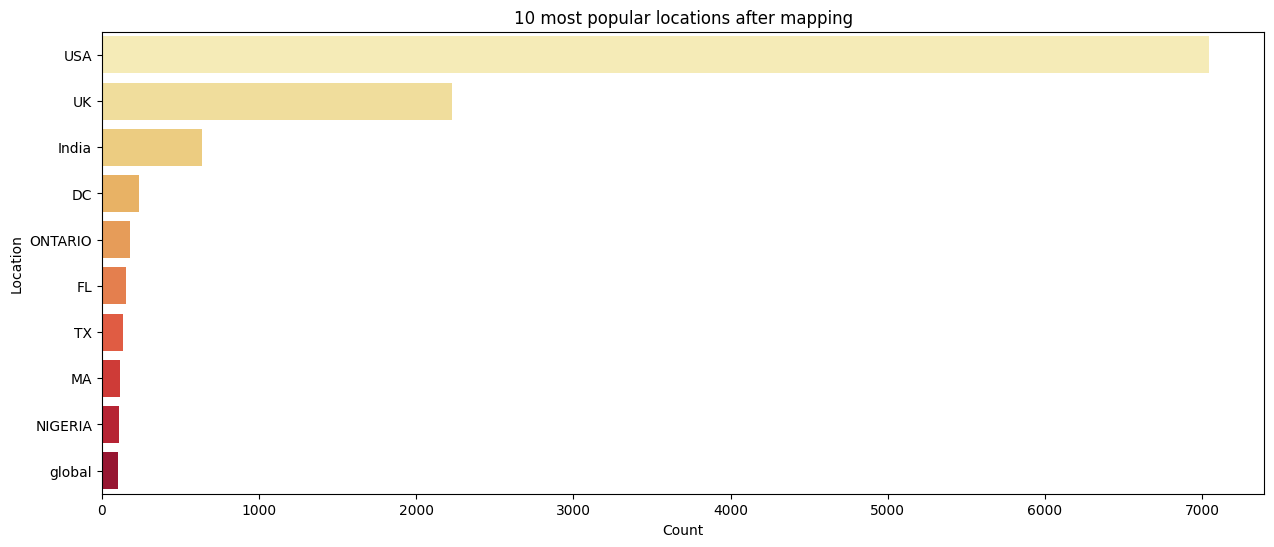

Теперь в train 3028 уникальных локаций


In [55]:
train, test = train_test_split(df, test_size=0.3, random_state=0) # снова разделим
top10 = train[train['WiderLocation'] != 'Unknown']['WiderLocation'].value_counts().head(10)

plt.figure(figsize=(15, 6))
sns.barplot(y=top10.index, x=top10.values, palette='YlOrRd')
plt.title('10 most popular locations after mapping')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()
print(f'Теперь в train {train['WiderLocation'].nunique()} уникальных локаций')

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [56]:
vcnt = df['WiderLocation'].value_counts()
vcnt = vcnt[vcnt > 1]
print(f'Таких значений: {len(vcnt)} для всех данных')

vcnt_train = train['WiderLocation'].value_counts()
vcnt_train = vcnt_train[vcnt_train > 1]
print(f'Таких значений: {len(vcnt_train)} для train сета')
vcnt_train

Таких значений: 994 для всех данных
Таких значений: 760 для train сета


WiderLocation
USA                      7044
Unknown                  4944
UK                       2227
India                     636
DC                        234
                         ... 
guernsey                    2
phobos resist               2
MADHYA PRADESH 462001       2
fort mcmurray               2
suva                        2
Name: count, Length: 760, dtype: int64

In [57]:
vcnt.index

Index(['USA', 'Unknown', 'UK', 'India', 'DC', 'ONTARIO', 'FL', 'TX', 'MA',
       'NIGERIA',
       ...
       'MOSTLY', 'HUGGING TREES', 'FIFE & ELSEWHERE', 'east rand', 'FLA',
       'downstage centre', 'BOSTON', 'OTTAWA', 'eastbourne',
       'brighton lass ??'],
      dtype='object', name='WiderLocation', length=994)

In [58]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', categories=[list(vcnt.index)]).fit(train[['WiderLocation']])
train_locs = ohe.transform(train[['WiderLocation']])
test_locs = ohe.transform(test[['WiderLocation']])

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [59]:
# векторизируем тексты
cv = CountVectorizer(tokenizer=custom_stem_tokenizer).fit(train['OriginalTweet']) 
tweets_train_cv = cv.transform(train['OriginalTweet'])
tweets_test_cv = cv.transform(test['OriginalTweet'])

tfidfv = TfidfVectorizer(tokenizer=custom_stem_tokenizer).fit(train['OriginalTweet'])
tweets_train_tf = tfidfv.transform(train['OriginalTweet'])
tweets_test_tf = tfidfv.transform(test['OriginalTweet'])

In [60]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler() # отскалируем, standardscaler не подойдет, выйдет ошибка, что матрица должна остаться разреженной, можно с with_mean=False, но не очень получается
tweets_train_cv = scaler.fit_transform(tweets_train_cv)
tweets_test_cv = scaler.transform(tweets_test_cv)

tweets_train_tf = scaler.fit_transform(tweets_train_tf)
tweets_test_tf = scaler.transform(tweets_test_tf)

In [61]:
from scipy.sparse import hstack # соединим признаки
X_train_cv, y_train = hstack((tweets_train_cv, train_locs)), train['SentimentCode']
X_test_cv, y_test = hstack((tweets_test_cv, test_locs)), test['SentimentCode']
X_train_tf = hstack((tweets_train_tf, train_locs))
X_test_tf = hstack((tweets_test_cv, test_locs))

In [62]:
lr_cv = LogisticRegression().fit(X_train_cv, y_train)
lr_tfidfv = LogisticRegression().fit(X_train_tf, y_train)

print(f'Accuracy CountVec: train - {accuracy_score(y_train, lr_cv.predict(X_train_cv)):.2f}, test - {accuracy_score(y_test, lr_cv.predict(X_test_cv)):.2f}')
print(f'Accuracy TfidfVec: train - {accuracy_score(y_train, lr_tfidfv.predict(X_train_tf)):.2f}, test - {accuracy_score(y_test, lr_tfidfv.predict(X_test_tf)):.2f}')

Accuracy CountVec: train - 0.97, test - 0.86
Accuracy TfidfVec: train - 0.97, test - 0.85


**Ответ:** Не сказал бы, что качество улучшилось, осталось на том же уровне (с точки зрения теста), но переобученность одной моделей выросла, судя по всему, из-за увеличения признакового пространства. Грустно.